In [18]:
import os
import torch
import torch.nn as nn
import torch_geometric.nn as geom_nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim as optim
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, precision_recall_curve

from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import matplotlib as mpl
from matplotlib import pyplot as plt
from copy import deepcopy
from torch.utils.data import TensorDataset, DataLoader
import importlib
#importlib.reload(utils)
import torch.optim.lr_scheduler as lr_scheduler
import scipy
from scipy.sparse import csr_matrix

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#torch.cuda.set_per_process_memory_fraction(1.0, device=device)

#define the graph of your problem 

sparse_graph = scipy.sparse.load_npz('/libre/chengs/data/unstructured_data/case_0/hessian_/case_0_sparse_matrix.npz')[:,:-1]

sparse_graph = sparse_graph[8192*3:8192*5,8192*3:8192*5]

pt_tensor = torch.sparse_coo_tensor(sparse_graph.nonzero(), sparse_graph.data, sparse_graph.shape).to_sparse().to(device)

this_edge_index = torch.from_numpy(np.concatenate((sparse_graph.nonzero()[0].reshape(-1,1),sparse_graph.nonzero()[1].reshape(-1,1)),axis=1).T).to(device)

this_edge_weight = torch.ones(this_edge_index.shape[1]).to(device)

#num_nodes = sparse_graph.shape[1]

data_list = []
for sim in range(30):
    for steps in range(1,100):
        try:
            x = np.load('/libre/chengs/data/unstructured_data/case_0/hessian_/foward_soln_timestep_'+'{0:g}'
                        .format(float("{:.2f}".format(steps*0.02)))+'.npy')
            data_list.append(x)
        except:
            pass

data_ens = np.array(data_list)/np.max(np.array(data_list),axis= (0,1))

#train_data = torch.from_numpy(data_ens[:2000,:-1,:]).to(torch.float32)
#validation_data = torch.from_numpy(data_ens[2000:,:-1,:]).to(torch.float32)

#train_data = torch.from_numpy(data_ens[:2000,:-1,0]).to(torch.float32).unsqueeze(1)[:,:,8192*3:8192*5]
#validation_data = torch.from_numpy(data_ens[2000:,:-1,0]).to(torch.float32).unsqueeze(1)[:,:,8192*3:8192*5]

train_data = torch.from_numpy(data_ens[:2000,:-1,0]).to(torch.float32).unsqueeze(1)[:,:,:]
validation_data = torch.from_numpy(data_ens[2000:,:-1,0]).to(torch.float32).unsqueeze(1)[:,:,:]


In [19]:
num_features = train_data.shape[1]
num_nodes = train_data.shape[2]

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(validation_data, batch_size=8, shuffle=True)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(1, 4, kernel_size=8, padding='same', dilation=2)
        self.dropout1 = nn.Dropout(0.1)
        self.pool1 = nn.MaxPool1d(5)
        
        self.conv2 = nn.Conv1d(4, 4, kernel_size=8, padding='same', dilation=2)
        self.dropout2 = nn.Dropout(0.1)
        self.pool2 = nn.MaxPool1d(5)

        self.conv3 = nn.Conv1d(4, 1, kernel_size=8, padding='same', dilation=2)
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.dropout3 = nn.Dropout(0.1)
        self.pool3 = nn.MaxPool1d(5)

        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(1, 30)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.leaky_relu(x)
        x = self.dropout3(x)
        x = self.pool3(x)
        
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense1 = nn.Linear(30, 512)  # Reduce feature dimensions to meet the requirement
        self.upsample1 = nn.Upsample(size=1024)  # First upsampling

        self.conv1 = nn.Conv1d(1, 1, kernel_size=8, padding=4, dilation=2)
        
        self.linear = nn.Linear(1018,num_nodes)
        #self.upsample2 = nn.Upsample(size=16384)  # Second upsampling to reach the target size
        
        self.conv2 = nn.Conv1d(1, 1, kernel_size=1, padding='same')  # Final convolution to adjust channel
        self.leaky_relu = nn.LeakyReLU(0.3)

    def forward(self, x):
        x = self.dense1(x)
        x = x.view(-1, 1, 512)  # Reshape to match the convolution input dimensions
        
        x = self.upsample1(x)
        x = F.relu(self.conv1(x))
        #x = self.upsample2(x)
        x = self.linear(x)
        
        x = self.conv2(x)
        x = self.leaky_relu(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create the model
model = Autoencoder()

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Example of how to train (you need to add the actual data loading part)
# for inputs, targets in dataloader:
#     optimizer.zero_grad()
#     outputs = model(inputs)
#     loss = criterion(outputs, targets)
#     loss.backward()
#     optimizer.step()


In [23]:
from torchsummary import summary

summary(Decoder().to(device), (1, 30))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]          15,872
          Upsample-2              [-1, 1, 1024]               0
            Conv1d-3              [-1, 1, 1018]               9
            Linear-4             [-1, 1, 97148]      98,993,812
            Conv1d-5             [-1, 1, 97148]               2
         LeakyReLU-6             [-1, 1, 97148]               0
Total params: 99,009,695
Trainable params: 99,009,695
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 2.24
Params size (MB): 377.69
Estimated Total Size (MB): 379.94
----------------------------------------------------------------


In [24]:
def train_cae(model):
    num_epochs = 200
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=10)
    #scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0)
    sigmoid = nn.Sigmoid()

    for epoch in range(num_epochs):
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            output = model(data)
            #print('outputshape',output.shape)
            #print('sigmoid(data).shape',sigmoid(data).shape)
            #print('data.shape',data.shape)
            loss = criterion(output, sigmoid(data))
            loss.backward()
            optimizer.step()

        #before_lr = optimizer.param_groups[0]["lr"]
        #scheduler.step()
        #after_lr = optimizer.param_groups[0]["lr"]
        #print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

        if epoch % 10 == 0:
            with torch.no_grad():
                val_loss = 0
                for data in val_loader:
                    data =data.to(device)
                    output = model(data)
                    val_loss += criterion(output, sigmoid(data)).item()

                    #print(criterion(output, sigmoid(data)))

                val_loss /= len(val_loader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}, Val Loss: {val_loss:.8f}')
            

    torch.save(model,'/libre/chengs/model/1DCNN_advectingflow.pt')
    #torch.save(model,'/libre/chengs/model/ReorderGCN1DCNNautoencoder_advectingflow.pt')
    #torch.save(model,'/libre/chengs/model/FCNautoencoder_advectingflow.pt')

In [25]:
autoencoder = Autoencoder().to(device)
#autoencoder_gcn = torch.load('/libre/chengs/model/GCN1DCNNautoencoder_advectingflow.pt').to(device)
train_cae(autoencoder)

Epoch [1/200], Loss: 0.52303475, Val Loss: 0.52239375
Epoch [11/200], Loss: 0.00096752, Val Loss: 0.00105721
Epoch [21/200], Loss: 0.00082649, Val Loss: 0.00106514
Epoch [31/200], Loss: 0.00133618, Val Loss: 0.00105800
Epoch [41/200], Loss: 0.00142266, Val Loss: 0.00105331
Epoch [51/200], Loss: 0.00104213, Val Loss: 0.00104644
Epoch [61/200], Loss: 0.00116451, Val Loss: 0.00104206
Epoch [71/200], Loss: 0.00088628, Val Loss: 0.00101961
Epoch [81/200], Loss: 0.00095547, Val Loss: 0.00097074
Epoch [91/200], Loss: 0.00049319, Val Loss: 0.00088265
Epoch [101/200], Loss: 0.00071312, Val Loss: 0.00072718
Epoch [111/200], Loss: 0.00041515, Val Loss: 0.00049573
Epoch [121/200], Loss: 0.00030095, Val Loss: 0.00028809
Epoch [131/200], Loss: 0.00019532, Val Loss: 0.00021802
Epoch [141/200], Loss: 0.00019190, Val Loss: 0.00021073
Epoch [151/200], Loss: 0.00017671, Val Loss: 0.00020660
Epoch [161/200], Loss: 0.00019063, Val Loss: 0.00020320
Epoch [171/200], Loss: 0.00012557, Val Loss: 0.00020187
Epo

In [26]:
for i in range(5):
    train_cae(autoencoder)

Epoch [1/200], Loss: 0.00027359, Val Loss: 0.00020257
Epoch [11/200], Loss: 0.00020053, Val Loss: 0.00019034
Epoch [21/200], Loss: 0.00016128, Val Loss: 0.00018670
Epoch [31/200], Loss: 0.00006585, Val Loss: 0.00018525
Epoch [41/200], Loss: 0.00020446, Val Loss: 0.00017678
Epoch [51/200], Loss: 0.00025993, Val Loss: 0.00017149
Epoch [61/200], Loss: 0.00017461, Val Loss: 0.00016239
Epoch [71/200], Loss: 0.00011528, Val Loss: 0.00015167
Epoch [81/200], Loss: 0.00010489, Val Loss: 0.00014291
Epoch [91/200], Loss: 0.00009604, Val Loss: 0.00013053
Epoch [101/200], Loss: 0.00009640, Val Loss: 0.00011701
Epoch [111/200], Loss: 0.00007440, Val Loss: 0.00009989
Epoch [121/200], Loss: 0.00008663, Val Loss: 0.00008458
Epoch [131/200], Loss: 0.00003788, Val Loss: 0.00006891
Epoch [141/200], Loss: 0.00006311, Val Loss: 0.00005673
Epoch [151/200], Loss: 0.00004509, Val Loss: 0.00004364
Epoch [161/200], Loss: 0.00002684, Val Loss: 0.00003533
Epoch [171/200], Loss: 0.00002912, Val Loss: 0.00003015
Epo

KeyboardInterrupt: 

In [36]:
train_data = torch.from_numpy(data_ens[:2000,:-1,0]).to(torch.float32).unsqueeze(1)[1000:1002,:,:]

#s = list(train_data[0,0,:])
#train_data = train_data[:,:,sorted(range(len(s)), key=lambda k: s[k])]
#autoencoder_gcn = torch.load('/libre/chengs/model/GCN1DCNNautoencoder_advectingflow.pt').to(device)
autoencoder_gcn = torch.load('/libre/chengs/model/1DCNN_advectingflow.pt').to(device)

prediction = autoencoder_gcn(validation_data[0,:,:].unsqueeze(0).to(device)).detach().cpu().numpy().ravel()
original = validation_data[0,:,:].ravel()

#inverse_perm = np.argsort(sorted(range(len(s)), key=lambda k: s[k]))
#prediction = prediction[:,:,inverse_perm]
#original = original[:,inverse_perm]

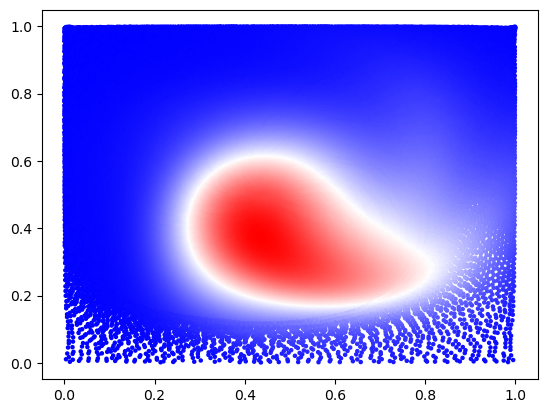

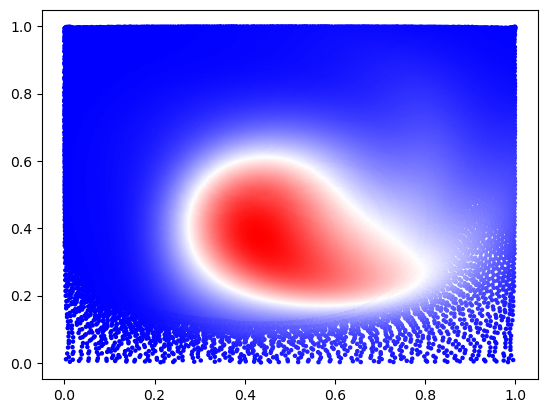

In [37]:

xyfile = '/libre/chengs/data/unstructured_data/case_0/hessian_/xy_coords.npy'
marker_size = 5 #upped this to make points more visible
# load the file
xycoords_check = np.load(xyfile)

# QC: check the solutions for each timestep manually
# create
#     print(values_check[-1][:,1])

plt.scatter(xycoords_check[:-1,0],xycoords_check[:-1,1],s = marker_size, c=prediction, cmap='bwr')
plt.show()
plt.close()

plt.scatter(xycoords_check[:-1,0],xycoords_check[:-1,1],s = marker_size, c=original, cmap='bwr')
plt.show()
plt.close()